In [1]:
%matplotlib inline
import carmcmc as cm
import numpy as np
import matplotlib.pyplot as plt

# set the CARMA model parameters
sigmay = 2.3  # dispersion in the time series
p = 5  # order of the AR polynomial
mu = 17.0  # mean of the time series
qpo_width = np.array([1.0/100.0, 1.0/300.0, 1.0/200.0])  # widths of of Lorentzian components
qpo_cent = np.array([1.0/5.0, 1.0/25.0])  # centroids of Lorentzian components
ar_roots = cm.get_ar_roots(qpo_width, qpo_cent) # compute the roots r_k from the Lorentzian function parameters
ar_coefs = np.poly(ar_roots)
ma_coefs = np.array([1.0, 4.5, 1.25, 0.0, 0.0])
# convert CARMA model variance to variance in the driving white noise
sigsqr = sigmay ** 2 / cm.carma_variance(1.0, ar_roots, ma_coefs=ma_coefs)  # carma_variance computes the autcovariance function

Text(0,0.5,'magnitude')

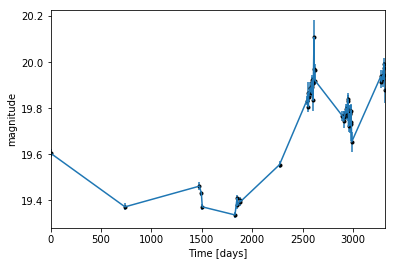

In [2]:
data = np.genfromtxt('LC_G_141827.dat')
juldate = data[:,0]  # time is given by the julian date
t = juldate - juldate.min()  # set first time value to zero for convenience. units of t are days.
y = data[:,1]  # i-band magnitudes
yerr = data[:,2]  # standard deviation in the measurement noise

plt.errorbar(t, y, yerr=yerr)
plt.plot(t, y, 'k.')
plt.xlim(t.min(), t.max())
plt.xlabel('Time [days]')
plt.ylabel('magnitude')

In [3]:
model = cm.CarmaModel(t, y, yerr, p=4, q=0)

In [4]:
%%capture capt
sample = model.run_mcmc(20000)

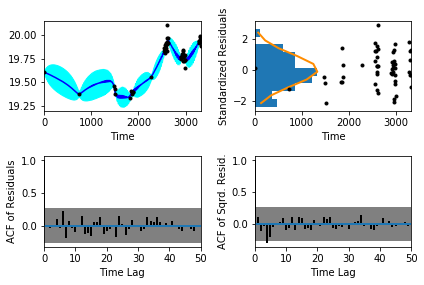

In [5]:
sample.assess_fit()

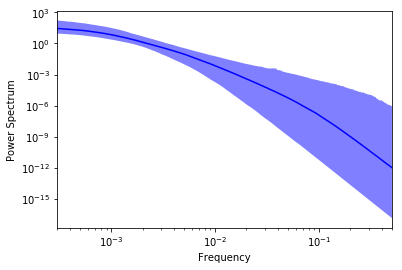

In [6]:
psd_low, psd_hi, psd_mid, frequencies = sample.plot_power_spectrum(percentile=95.0, nsamples=5000)

In [7]:
dt = t[1:] - t[:-1]
noise_level = 2.0 * np.mean(dt) * np.mean(yerr ** 2)

Text(0.000376389,0.0736159,'Measurement Noise Level')

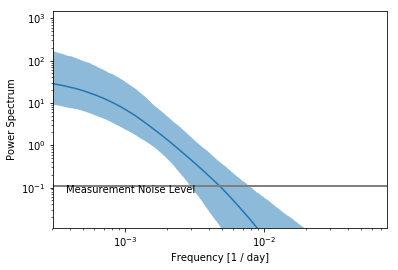

In [8]:


plt.loglog(frequencies, psd_mid)
plt.fill_between(frequencies, psd_hi, y2=psd_low, alpha=0.5)
plt.loglog(frequencies, np.ones(frequencies.size) * noise_level, color='grey', lw=2)
plt.ylim(noise_level / 10.0, plt.ylim()[1])
plt.xlim(frequencies.min(), frequencies[psd_hi > noise_level].max() * 10.0)
plt.ylabel('Power Spectrum')
plt.xlabel('Frequency [1 / day]')
plt.annotate("Measurement Noise Level", (1.25 * plt.xlim()[0], noise_level / 1.5))



Text(0.5,1,'Forecasting, Expected Value')

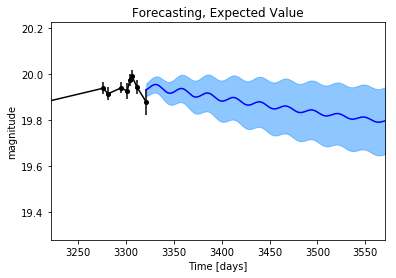

In [9]:
tpredict = t.max() + np.linspace(0.0, 250.0, 250)
ypredict, yp_var = sample.predict(tpredict)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tpredict, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tpredict, ypredict, 'b-')
plt.xlim(tpredict.min() - 100, tpredict.max())
plt.xlabel('Time [days]')
plt.ylabel('magnitude')
plt.title('Forecasting, Expected Value')

Text(0.5,1,'Forecasting, Simulated Paths')

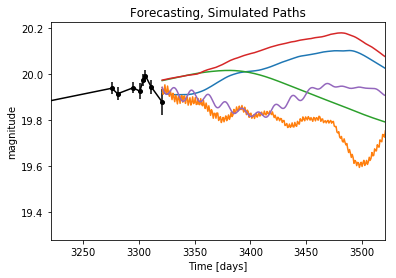

In [17]:


tpredict = t.max() + np.linspace(0.0, 200.0, 250)
npaths = 5
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
for i in range(npaths):
    ysim = sample.simulate(tpredict, bestfit='random')  # use a random draw of the CARMA parameters from its posterior
    plt.plot(tpredict, ysim)
plt.xlabel('Time [days]')
plt.ylabel('magnitude')
plt.xlim(tpredict.min()-100, tpredict.max())
plt.title('Forecasting, Simulated Paths')



/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


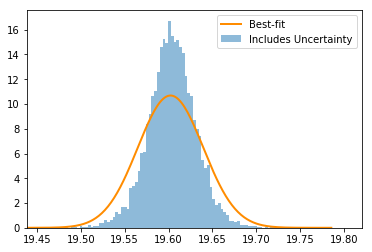

In [19]:
tpredict = 10.0
nsim = 10000
ysim = np.zeros(nsim)
for i in range(nsim):
    ysim[i] = sample.simulate(tpredict, bestfit='random')
yhat, yhvar = sample.predict(tpredict)
plt.hist(ysim, bins=100, alpha=0.5, histtype='stepfilled', normed=True, label='Includes Uncertainty')
ymin, ymax = plt.xlim()
ygrid = np.linspace(ymin, ymax, 200)
predictive_pdf = 1.0 / np.sqrt(2.0 * np.pi * yhvar) * np.exp(-0.5 * (ygrid - yhat) ** 2 / yhvar)
plt.plot(ygrid, predictive_pdf, color='DarkOrange', lw=2, label='Best-fit')
plt.xlim(ymin, ymax + 0.1 * (ymax - ymin))
plt.legend(loc='upper right')

Text(0.5,1,'Interpolation, Simulated Paths')

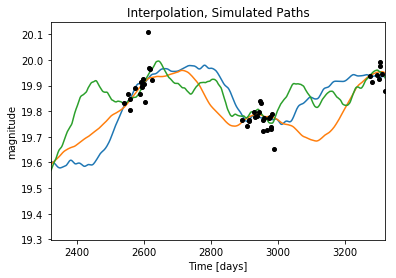

In [20]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
npaths = 3
for i in range(npaths):
    ysim = sample.simulate(tinterp, bestfit='random')
    plt.plot(tinterp, ysim)
plt.plot(t, y, 'ko', ms=4)
plt.xlabel('Time [days]')
plt.ylabel('magnitude')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolation, Simulated Paths')